In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
import cv2

In [2]:
def distance(pt1, pt2):
    return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def get_side_lengths(shape):
    xs, ys = shape.boundary.xy
    pts = list(zip(xs, ys))
    lengths = []
    for i in range(len(pts)-1):
        lengths.append(distance(pts[i], pts[i+1]))
    assert len(lengths) == 4
    return sorted(lengths)

In [3]:
f = fiona.open("./Delmarva_PL_House_Final/Delmarva_PL_House_Final.shp","r")
total_num = 0
valid_num = 0

side_lengths = []
areas = []
for row in f:
    if row["geometry"]["type"] == "Polygon":
        shape = shapely.geometry.shape(row["geometry"])
        num_points = len(row["geometry"]["coordinates"][0])
        if num_points == 5:
            side_lengths.append(get_side_lengths(shape))
            areas.append(shape.area)
            valid_num += 1
    total_num += 1
f.close()

side_lengths = np.array(side_lengths)

In [4]:
valid_num / total_num, valid_num, total_num

(0.9363145989211763, 5381, 5747)

In [5]:
side_lengths

array([[ 14.15593787,  14.30949002, 151.09690676, 152.02926322],
       [ 20.57984789,  22.52853343, 169.21989547, 170.90772434],
       [ 21.59646681,  22.62536048, 170.66296132, 171.50185856],
       ...,
       [ 13.89065278,  15.57593536, 151.9792628 , 152.90058817],
       [ 13.29517455,  16.07224468, 151.93127882, 154.41772488],
       [ 14.53044854,  14.97881197, 151.72125519, 152.35183599]])

In [6]:
short_sides = side_lengths[:,:2].mean(axis=1)
long_sides = side_lengths[:,2:].mean(axis=1)

In [7]:
short_sides.mean(), short_sides.std()

(16.504778354770394, 3.3814315169549136)

In [8]:
long_sides.mean(), long_sides.std()

(147.20164583861254, 26.644982676765707)

In [9]:
aspect_rations = long_sides / short_sides

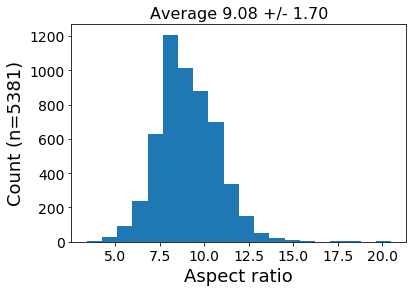

In [10]:
plt.figure()
plt.hist(long_sides / short_sides,bins=20)
plt.xlabel("Aspect ratio", fontsize=18)
plt.ylabel("Count (n=%d)" % (long_sides.shape[0]), fontsize=18)
plt.title("Average %0.2f +/- %0.2f" % (aspect_rations.mean(), aspect_rations.std()), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()

# Generate Rec

In [11]:
aspect_rations

array([10.64892371,  7.89005779,  7.73746452, ..., 10.34662885,
       10.43159432, 10.30432772])

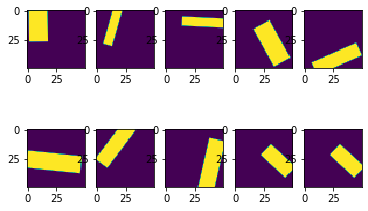

In [222]:
from skimage.transform import rotate
from skimage.draw import circle
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_rectangle(aspect_ratio, height, width, rotation, min_pixel=100):
    redo = True
    img = np.zeros((width, height), dtype=np.uint8)
    while redo == True:
        start_x = np.random.randint(width//2)
        start_y = np.random.randint(height//2)

        # Chooses from short side...
        short_side = np.random.randint(height//3)
        long_side  = short_side * aspect_ratio

        end_y = int(start_y + short_side)
        end_x = int(start_x + long_side)

        # Get center
        center_x = (max(start_x,end_x) - min(start_x, end_x)) / 2
        center_y = (max(start_y,end_y) - min(start_y, end_y)) / 2

        rec = cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (255,255,255), -1)
        img = rotate(image=img, angle=rotation)
        
        # Make sure there's no empty images (at least 100 pixels are in img)
        if np.count_nonzero(img) < (min_pixel):
            # reset
            redo = True
            img = np.zeros((width, height), dtype=np.uint8)
        else:
            redo = False
        
        plt.imshow(img)
            
    return img

for i in range(10):
    res = generate_rectangle(np.random.choice(aspect_rations), 50, 50, np.random.randint(360))
    plt.subplot(2, 5, i+1)
    plt.imshow(res)

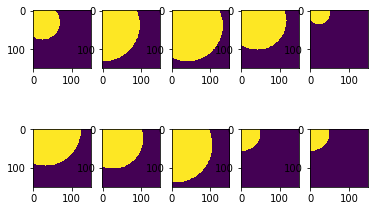

In [241]:
def generate_circle(x,y,r,height,width):
    img = np.zeros((150, 150), dtype=np.uint8)
    circle = cv2.circle(img, (x,y), r, (255, 255, 255), -1) 
    plt.imshow(circle)
    return img

for i in range(10):
    img = generate_circle(np.random.randint(50), np.random.randint(50), np.random.randint(50*2), 50, 50)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)